Tema 3

In [2]:
!unzip DataSet.zip

Archive:  DataSet.zip
   creating: News Articles/business/
  inflating: News Articles/business/001.txt  
  inflating: News Articles/business/002.txt  
  inflating: News Articles/business/003.txt  
  inflating: News Articles/business/004.txt  
  inflating: News Articles/business/005.txt  
  inflating: News Articles/business/006.txt  
  inflating: News Articles/business/007.txt  
  inflating: News Articles/business/008.txt  
  inflating: News Articles/business/009.txt  
  inflating: News Articles/business/010.txt  
  inflating: News Articles/business/011.txt  
  inflating: News Articles/business/012.txt  
  inflating: News Articles/business/013.txt  
  inflating: News Articles/business/014.txt  
  inflating: News Articles/business/015.txt  
  inflating: News Articles/business/016.txt  
  inflating: News Articles/business/017.txt  
  inflating: News Articles/business/018.txt  
  inflating: News Articles/business/019.txt  
  inflating: News Articles/business/020.txt  
  inflating: News Art

In [82]:
from dataclasses import dataclass

@dataclass
class DataItem:
    id: int
    text: str
    summary: str
    category: str
    tokenize_words: []
    tokenize_sentences: []
    extract_stop_words: []
    lemmatization: []

In [83]:
# read data from data set
import os

dataset = []
categories = []
for cat_name in os.listdir("./News Articles"):
    print("Category: ", cat_name)
    dir_path = "./News Articles/" + cat_name
    categories.append(cat_name)
    for filename in os.listdir(dir_path):
        file_path = dir_path + "/" + filename
        with open(file_path, 'r', encoding='utf-8') as f:
            try:
                content = f.read().strip()
            except Exception as ex:
                print(f"ERROR: Could not decode {file_path}: {ex}")
        with open(f"./Summaries/{cat_name}/{filename}", 'r', encoding='utf-8') as f:
            summary = f.read().strip()
        dataset.append(DataItem(
            id=int(filename.split('.')[0]),
            text=content,
            summary=summary,
            category=cat_name,
            tokenize_words=[],
            tokenize_sentences=[],
            extract_stop_words=[],
            lemmatization=[],
        ))
dataset.sort(key=lambda item: (item.category, item.id))

Category:  entertainment
Category:  tech
Category:  politics
Category:  sport
Category:  business


In [84]:
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import download
download('wordnet')
download('punkt')

def process_text(dataset, use_stop_words = True, use_lematization = True):
    lemmatizer = WordNetLemmatizer()

    stop_words = [line.strip().lower() for line in open("stop_words")]
    for item in dataset:
      item.tokenize_words = word_tokenize(item.text)
      sentences = item.text.splitlines()
      tokenize_sentences = [sent_tokenize(s) for s in sentences if len(s) != 0]
      item.tokenize_sentences = [item for sublist in tokenize_sentences for item in sublist]

      if use_stop_words:
        item.extract_stop_words = [
            w.lower() for w in item.tokenize_words
            if w.lower() not in stop_words and len(w) > 2]
      if use_lematization:
          item.lemmatization = [lemmatizer.lemmatize(w) for w in item.extract_stop_words]

process_text(dataset)


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [85]:
categories_entries = {c: [] for c in categories}

for item in dataset:
    categories_entries[item.category].append(item)

In [86]:
import random
from random import shuffle

random.seed(13)

data_train = []
data_test = []

for l in categories_entries.values():
    shuffle(l)
    N = int(0.75 * len(l))
    data_train += l[:N]
    data_test += l[N:]

In [87]:
def count_words(data_set, use_stop_words=True, use_lematization=True):
    vocabulary = {}
    no_of_words = {c: 0 for c in categories}
    cat_to_indx = {}
    i = 0
    for category in categories_entries:
      cat_to_indx[category] = i
      for data_item in data_set:
        if data_item.category == category:
          if use_lematization:
            item_words = data_item.lemmatization
          elif use_stop_words:
            item_words = data_item.extract_stop_words
          else:
            item_words = data_item.tokenize_words
          for word in item_words:
            no_of_words[category] += 1
            if word in vocabulary:
              vocabulary[word][i] += 1
            else:
              vocabulary[word] = [0, 0, 0, 0, 0]
              vocabulary[word][i] = 1
      i += 1
    return (vocabulary, no_of_words, cat_to_indx)

In [88]:
from math import log

def predict(params, data_item, alpha=1, use_stop_words=True, use_lematization=True):
    (vocabulary, no_of_words, cat_to_indx) = params
    log_cat = {c: log(1.0 / len(categories)) for c in categories}
    nr_words = {c: [] for c in categories}
    if use_lematization:
      item_words = data_item.lemmatization
    elif use_stop_words:
      item_words = data_item.extract_stop_words
    else:
      item_words = data_item.tokenize_words
    for word in item_words:
        if word in vocabulary:
          nr_words = vocabulary[word]
        else:
          nr_words = [0] * len(categories)

        for category in categories_entries:
          log_cat[category] += log((nr_words[cat_to_indx[category]] + alpha) 
              / (no_of_words[category] + len(vocabulary) * alpha))

    max_elem = max(log_cat, key=log_cat.get)
    return max_elem




use stop words: False , use lematization: False

               precision    recall  f1-score   support

entertainment       0.98      0.91      0.95       128
         tech       0.98      0.97      0.97        97
     politics       0.93      0.99      0.96       105
        sport       1.00      0.99      1.00       128
     business       0.95      0.99      0.97       101

     accuracy                           0.97       559
    macro avg       0.97      0.97      0.97       559
 weighted avg       0.97      0.97      0.97       559

[[117   1   6   0   4]
 [  1  94   2   0   0]
 [  0   0 104   0   1]
 [  1   0   0 127   0]
 [  0   1   0   0 100]]


use stop words: True , use lematization: False

               precision    recall  f1-score   support

entertainment       0.99      0.91      0.95       128
         tech       0.97      0.98      0.97        97
     politics       0.92      0.98      0.95       105
        sport       1.00      0.99      1.00       128
     busi

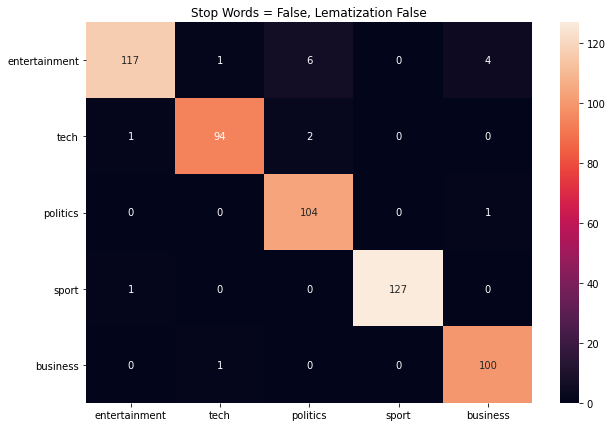

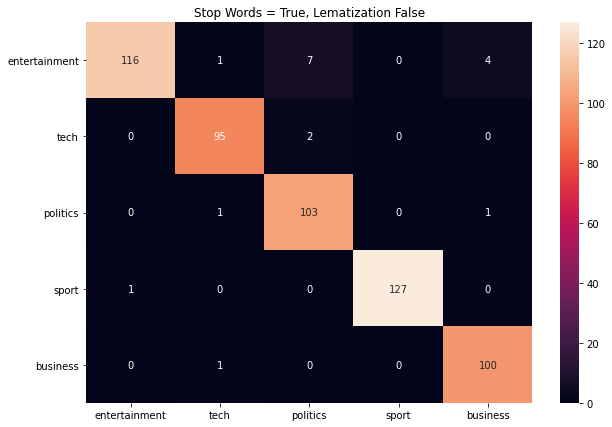

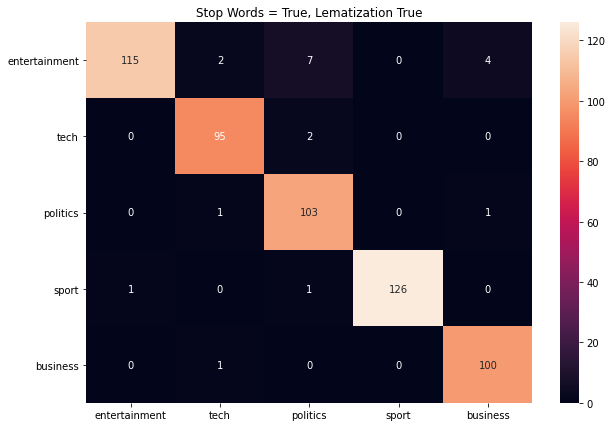

In [89]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

plot_values = {"(False, False)": (), "(True, False)" : (), "(True, True)" : ()}

def evaluate2(data, params, prediction_func, use_stop_words, use_lematization):
    y_true = []
    y_pred = []
    target_names = []
    for category in categories_entries:
        target_names.append(str(category))

    for data_item in data:
        cat = prediction_func(params, data_item, 1, use_stop_words, use_lematization)
        y_true.append(data_item.category)
        y_pred.append(cat)

    print()
    array = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(array, index = [i for i in ["entertainment", "tech", "politics", "sport", "business"]],
                  columns = [i for i in ["entertainment", "tech", "politics", "sport", "business"]])
    plt.figure(figsize = (10,7))
   
    heatmap = sn.heatmap(df_cm, annot=True, fmt='g')
    loc, labels = plt.xticks()
    heatmap.set_yticklabels(labels, rotation=0)
    heatmap.set_title("Stop Words = " + str(use_stop_words) + ", " + "Lematization " + str(use_lematization))

    precision,recall,fscore,_=score(y_true,y_pred,average='macro')
    plot_values["(" + str(use_stop_words) + ", " + str(use_lematization) + ")"] = (precision,recall,fscore)

    print()
    print("use stop words:", use_stop_words, ", use lematization:", use_lematization)
    print()      
    print(classification_report(y_true, y_pred, target_names=target_names))
    print(confusion_matrix(y_true, y_pred))
    return (precision, recall, fscore)

for use_stop_words, use_lematization in [(False, False), (True, False), (True, True)]:
    params = count_words(data_train, use_stop_words=use_stop_words, use_lematization=use_lematization)
    evaluate2(data_test, params, predict, use_stop_words=use_stop_words, use_lematization=use_lematization)

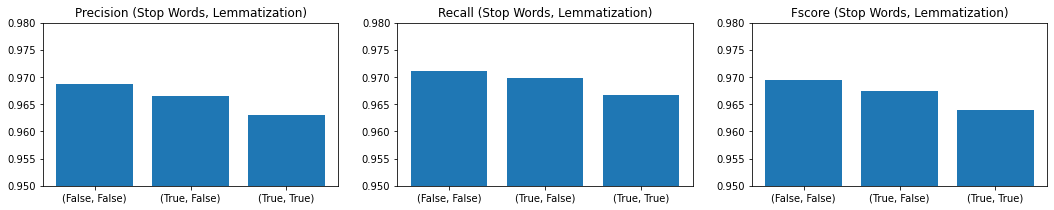

In [90]:
names = []
prec = []
rec = []
fsc = []
for key, (precision,recall,fscore) in plot_values.items():
  names.append(key)
  prec.append(precision)
  rec.append(recall)
  fsc.append(fscore)

plt.figure(figsize=(18, 3))

p1 = plt.subplot(131)
p1.set_title("Precision (Stop Words, Lemmatization)")
plt.ylim([0.95, 0.98])
plt.bar(names, prec)

p2 = plt.subplot(132)
p2.set_title("Recall (Stop Words, Lemmatization)")
plt.ylim([0.95, 0.98])
plt.bar(names, rec)

p3 = plt.subplot(133)
p3.set_title("Fscore (Stop Words, Lemmatization)")
plt.ylim([0.95, 0.98])
plt.bar(names, fsc)
plt.show()


Sumarizarea documentelor

In [91]:
def process_sentences(sentences, use_stop_words=True, use_lematization=True):
  s = []
  lemmatizer = WordNetLemmatizer()
  stop_words = [line.strip().lower() for line in open("stop_words")]
  for sent in sentences:
      split_sent = word_tokenize(sent)
      if use_stop_words:
        split_sent = [
            w.lower() for w in split_sent
            if w.lower() not in stop_words and len(w) > 2]
      if use_lematization:
        split_sent = [lemmatizer.lemmatize(w) for w in split_sent]
      s.append(split_sent)
  return s

def process_sentence(sent, use_stop_words=True, use_lematization=True):
  lemmatizer = WordNetLemmatizer()
  stop_words = [line.strip().lower() for line in open("stop_words")]
  split_sent = word_tokenize(sent)
  if use_stop_words:
    split_sent = [
        w.lower() for w in split_sent
        if w.lower() not in stop_words and len(w) > 2]
  if use_lematization:
    split_sent = [lemmatizer.lemmatize(w) for w in split_sent]
  return split_sent


In [92]:
def process_summary(summary, use_stop_words=False, use_lematization=False):
    sentences = []
    res = []
    lemmatizer = WordNetLemmatizer()
    stop_words = [line.strip().lower() for line in open("stop_words")]
    sentences = summary.splitlines()
    tokenize_sentences = [sent_tokenize(s) for s in sentences if len(s) != 0]
    sentences = [item for sublist in tokenize_sentences for item in sublist]
    for sent in sentences:
      split_sent = word_tokenize(sent)
      if use_stop_words:
        split_sent = [
            w.lower() for w in split_sent
            if w.lower() not in stop_words and len(w) > 2]
      if use_lematization:
        split_sent = [lemmatizer.lemmatize(w) for w in split_sent]
      res.append(split_sent)

    return res


def process_summary_sent(summary):
    res = []
    lemmatizer = WordNetLemmatizer()
    sentences = summary.splitlines()
    tokenize_sentences = [sent_tokenize(s) for s in sentences if len(s) != 0]
    res = [item for sublist in tokenize_sentences for item in sublist]
    return res

In [93]:
def count_sentences_words(data_set, use_stop_words=True, use_lematization=True):
    vocabulary = {}
    no_of_words = {"in": 0, "out": 0}
    
    for data_item in data_set:
      summary_sent = process_summary_sent(data_item.summary)
      for sent in data_item.tokenize_sentences:
        processed_sent = process_sentence(sent, use_stop_words=use_stop_words, use_lematization=use_lematization)
        if sent in summary_sent:
          for word in processed_sent:
            no_of_words["in"] += 1
            if word in vocabulary:
              vocabulary[word][0] += 1
            else:
              vocabulary[word] = [0, 0]
              vocabulary[word][0] = 1
        else:
          for word in processed_sent:
            no_of_words["out"] += 1
            if word in vocabulary:
              vocabulary[word][1] += 1
            else:
              vocabulary[word] = [0, 0]
              vocabulary[word][1] = 1
        
    return (vocabulary, no_of_words)

In [94]:
def count_sentences_bigrams(data_set, use_stop_words=True, use_lematization=True):
    vocabulary = {}
    no_of_words = {"in": 0, "out": 0}
    
    for data_item in data_set:
      summary_sent = process_summary_sent(data_item.summary)
      for sent in data_item.tokenize_sentences:
        processed_sent = process_sentence(sent, use_stop_words=use_stop_words, use_lematization=use_lematization)
        if sent in summary_sent:
          for idx in range(0, len(processed_sent) - 1):
            no_of_words["in"] += 1
            word = processed_sent[idx] + ":" + processed_sent[idx + 1]
            if word in vocabulary:
              vocabulary[word][0] += 1
            else:
              vocabulary[word] = [0, 0]
              vocabulary[word][0] = 1
        else:
          for idx in range(0, len(processed_sent) - 1):
            no_of_words["out"] += 1
            word = processed_sent[idx] + ":" + processed_sent[idx + 1]
            if word in vocabulary:
              vocabulary[word][1] += 1
            else:
              vocabulary[word] = [0, 0]
              vocabulary[word][1] = 1
        
    return (vocabulary, no_of_words)


In [95]:
def predict_sent_words(params, data_item, alpha=1, use_stop_words=True, use_lematization=True):
    (vocabulary, no_of_words) = params
    log_cat = {"in": log(0.5), "out": log(0.5)}
    nr_words = {"in": [], "out": []}
    item_words = process_sentence(data_item, use_stop_words=use_stop_words, use_lematization=use_lematization)
    for word in item_words:
        if word in vocabulary:
          nr_words = vocabulary[word]
        else:
          nr_words = [0, 0]

        log_cat["in"] += log((nr_words[0] + alpha) 
            / (no_of_words["in"] + len(vocabulary) * alpha))
        log_cat["out"] += log((nr_words[1] + alpha) 
            / (no_of_words["out"] + len(vocabulary) * alpha))

    max_elem = max(log_cat, key=log_cat.get)
    return max_elem

In [96]:
def predict_sent_bigrams(params, data_item, alpha=1, use_stop_words=True, use_lematization=True):
    (vocabulary, no_of_words) = params
    log_cat = {"in": log(0.5), "out": log(0.5)}
    nr_words = {"in": [], "out": []}
    item_words = process_sentence(data_item, use_stop_words=use_stop_words, use_lematization=use_lematization)
    for idx in range(0, len(item_words) - 1):
        word = item_words[idx] + ":" + item_words[idx + 1]
        if word in vocabulary:
          nr_words = vocabulary[word]
        else:
          nr_words = [0, 0]

        log_cat["in"] += log((nr_words[0] + alpha) 
            / (no_of_words["in"] + len(vocabulary) * alpha))
        log_cat["out"] += log((nr_words[1] + alpha) 
            / (no_of_words["out"] + len(vocabulary) * alpha))

    max_elem = max(log_cat, key=log_cat.get)
    return max_elem

In [97]:
def predict_summary_words(params, data_item, alpha=1, use_stop_words=True, use_lematization=True):
    my_summary = []
    for sent in data_item.tokenize_sentences:
        pred = predict_sent_words(params, sent, alpha=alpha, use_stop_words=use_stop_words, use_lematization=use_lematization)
        if pred == "in":
            my_summary.append(sent)
    return my_summary

def predict_summary_bigrams(params, data_item, alpha=1, use_stop_words=True, use_lematization=True):
    my_summary = []
    for sent in data_item.tokenize_sentences:
        pred = predict_sent_bigrams(params, sent, alpha=alpha, use_stop_words=use_stop_words, use_lematization=use_lematization)
        if pred == "in":
            my_summary.append(sent)
    return my_summary

In [98]:
!pip install rouge-score
from rouge_score import rouge_scorer

rouge_values = {"Uni - (False, False)": (), "Uni - (True, False)" : (), "Uni - (True, True)" : (), "Bi - (False, False)": (), "Bi - (True, False)" : (), "Bi - (True, True)" : ()}

def rouge_1(data, params, prediction_func, use_stop_words, use_lematization):
    for data_item in data:
      my_summary = predict_summary_words(params, data_item, 1, use_stop_words, use_lematization)
      summary = ""
      for sent in my_summary:
        summary += sent
      ref_summary = data_item.summary

      scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=False)
      scores = scorer.score(summary, ref_summary)
      rouge_values["Uni - (" + str(use_stop_words) + ", " + str(use_lematization) + ")"] = (scores['rouge1'][0], scores['rouge1'][1], scores['rouge1'][2])
      print(scores)
      return scores

def rouge_2(data, params, prediction_func, use_stop_words, use_lematization):
    for data_item in data:
      my_summary = predict_summary_bigrams(params, data_item, 1, use_stop_words, use_lematization)
      summary = ""
      for sent in my_summary:
        summary += sent
      ref_summary = data_item.summary

      scorer = rouge_scorer.RougeScorer(['rouge2', 'rougeL'], use_stemmer=False)
      scores = scorer.score(summary, ref_summary)
      rouge_values["Bi - (" + str(use_stop_words) + ", " + str(use_lematization) + ")"] = (scores['rouge2'][0], scores['rouge2'][1], scores['rouge2'][2])
      print(scores)
      return scores

for use_stop_words, use_lematization in [(False, False), (True, False), (True, True)]:
    params = count_sentences_words(data_train, use_stop_words=use_stop_words, use_lematization=use_lematization)
    print()
    print("Use stop words:", use_stop_words, ", Use lematization:", use_lematization)
    precision_test, recall_test = rouge_1(
        data_test, params, predict, use_stop_words=use_stop_words, use_lematization=use_lematization)
    

for use_stop_words, use_lematization in [(False, False), (True, False), (True, True)]:
    params = count_sentences_bigrams(data_train, use_stop_words=use_stop_words, use_lematization=use_lematization)
    print()
    print("Use stop words:", use_stop_words, ", Use lematization:", use_lematization)
    precision_test, recall_test = rouge_2(
        data_test, params, predict, use_stop_words=use_stop_words, use_lematization=use_lematization)
    



Use stop words: False , Use lematization: False
{'rouge1': Score(precision=0.7786885245901639, recall=0.8558558558558559, fmeasure=0.8154506437768241), 'rougeL': Score(precision=0.6065573770491803, recall=0.6666666666666666, fmeasure=0.6351931330472104)}

Use stop words: True , Use lematization: False
{'rouge1': Score(precision=0.8278688524590164, recall=0.6392405063291139, fmeasure=0.7214285714285715), 'rougeL': Score(precision=0.6065573770491803, recall=0.46835443037974683, fmeasure=0.5285714285714286)}

Use stop words: True , Use lematization: True
{'rouge1': Score(precision=0.8278688524590164, recall=0.6392405063291139, fmeasure=0.7214285714285715), 'rougeL': Score(precision=0.6065573770491803, recall=0.46835443037974683, fmeasure=0.5285714285714286)}

Use stop words: False , Use lematization: False
{'rouge2': Score(precision=0.743801652892562, recall=0.8181818181818182, fmeasure=0.7792207792207793), 'rougeL': Score(precision=0.6065573770491803, recall=0.6666666666666666, fmeasure

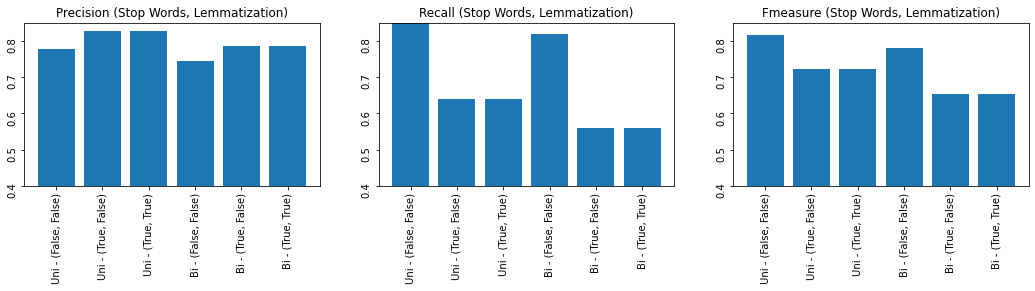

In [99]:
names = []
prec = []
rec = []
fsc = []
for key, (precision,recall,fscore) in rouge_values.items():
  names.append(key)
  prec.append(precision)
  rec.append(recall)
  fsc.append(fscore)

plt.figure(figsize=(18, 3))

p1 = plt.subplot(131)
p1.set_title("Precision (Stop Words, Lemmatization)")
p1.tick_params(labelrotation=90)
plt.ylim([0.4, 0.85])
plt.bar(names, prec)

p2 = plt.subplot(132)
p2.set_title("Recall (Stop Words, Lemmatization)")
p2.tick_params(labelrotation=90)
plt.ylim([0.4, 0.85])
plt.bar(names, rec)

p3 = plt.subplot(133)
p3.set_title("Fmeasure (Stop Words, Lemmatization)")
p3.tick_params(labelrotation=90)
plt.ylim([0.4, 0.85])
plt.bar(names, fsc)
plt.show()

5-fold cross-validation



use stop words: False , use lematization: False

               precision    recall  f1-score   support

entertainment       1.00      0.97      0.99       107
         tech       1.00      0.94      0.97        81
     politics       0.94      0.97      0.96        79
        sport       1.00      1.00      1.00        96
     business       0.94      1.00      0.97        82

     accuracy                           0.98       445
    macro avg       0.98      0.98      0.98       445
 weighted avg       0.98      0.98      0.98       445

[[104   0   1   0   2]
 [  0  76   4   0   1]
 [  0   0  77   0   2]
 [  0   0   0  96   0]
 [  0   0   0   0  82]]
{'rouge1': Score(precision=0.6601307189542484, recall=0.5401069518716578, fmeasure=0.5941176470588235), 'rougeL': Score(precision=0.3137254901960784, recall=0.25668449197860965, fmeasure=0.28235294117647064)}
{'rouge2': Score(precision=0.75, recall=0.3917525773195876, fmeasure=0.5146726862302483), 'rougeL': Score(precision=0.49019607

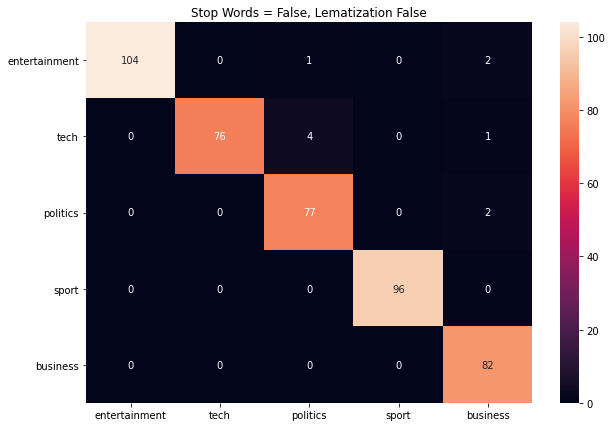

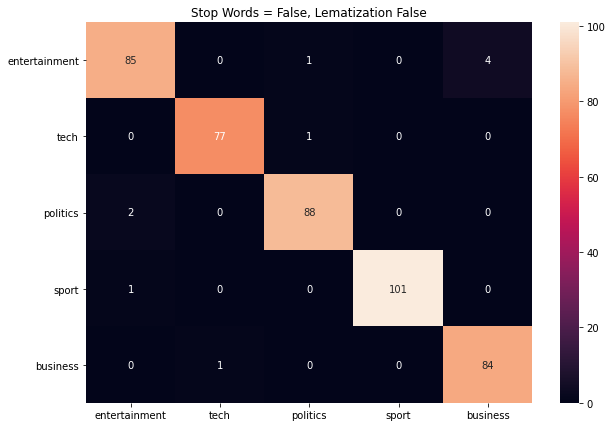

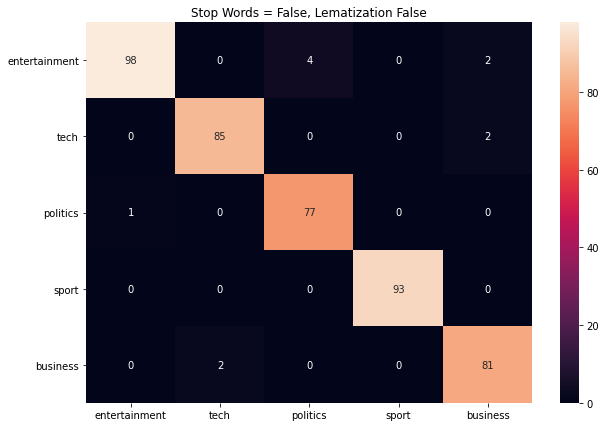

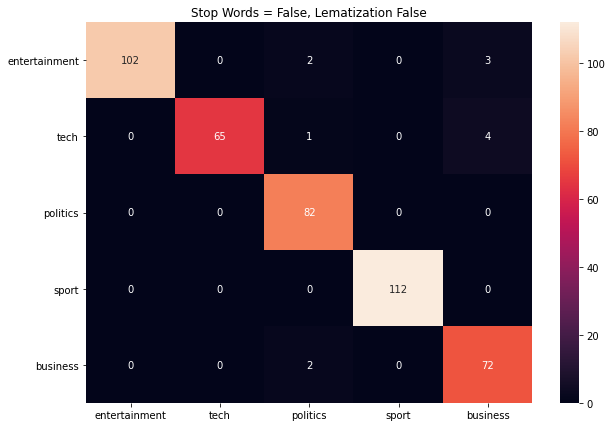

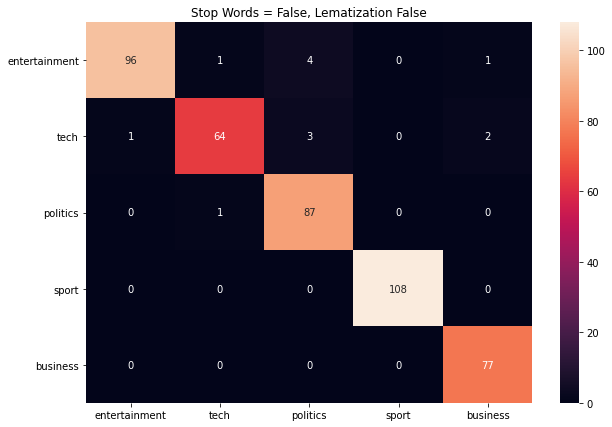

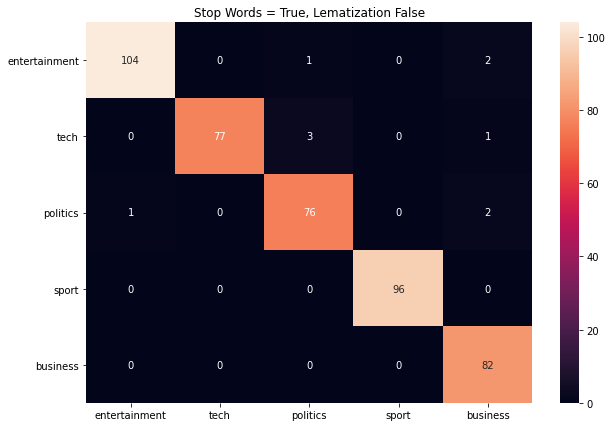

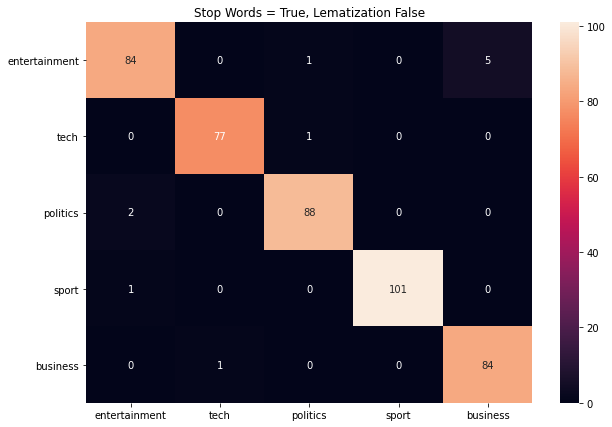

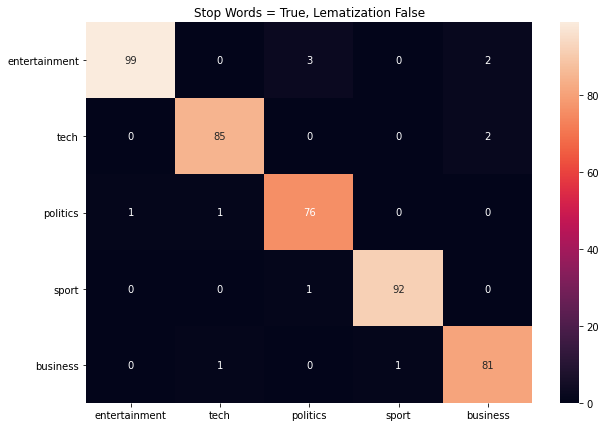

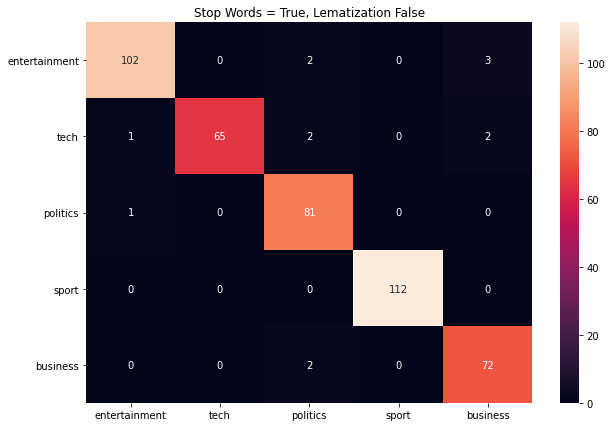

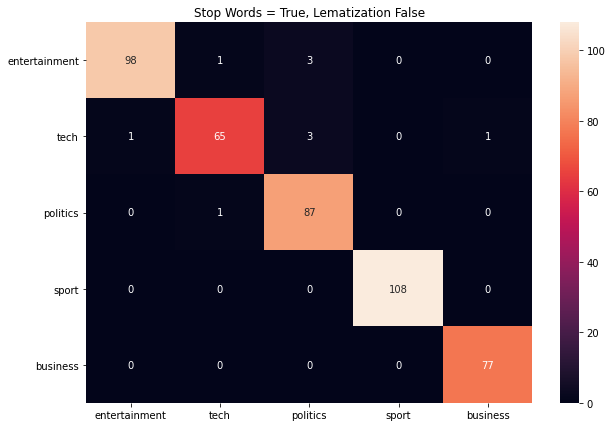

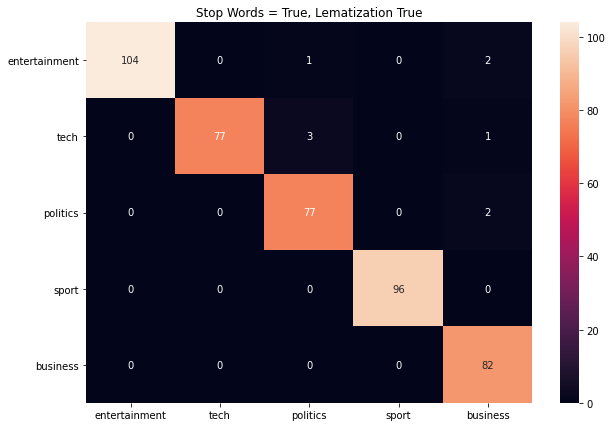

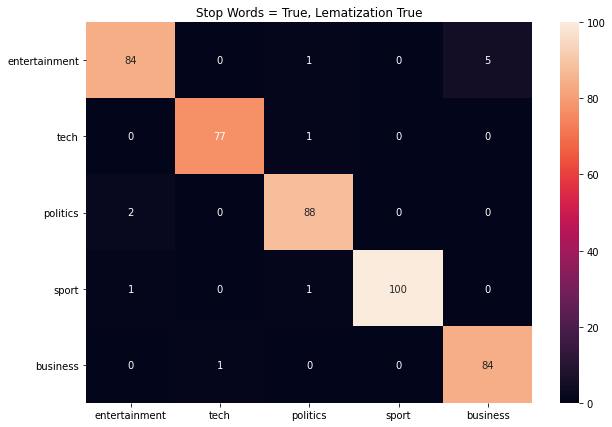

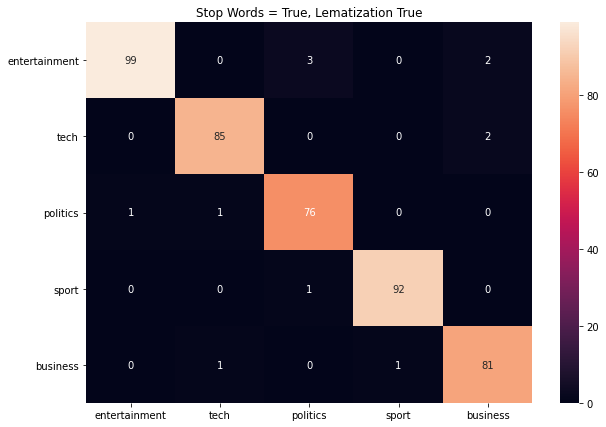

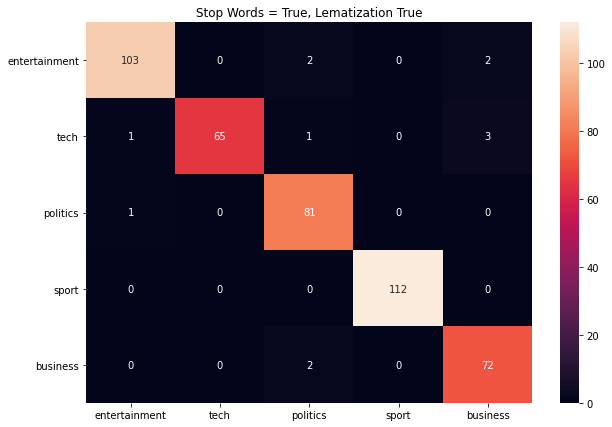

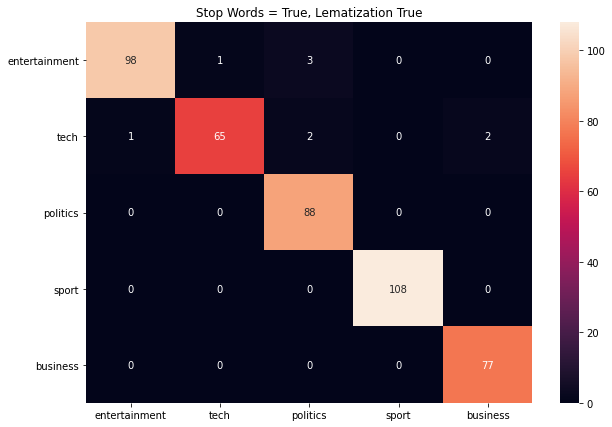

In [100]:
from sklearn.model_selection import KFold
import statistics 

kf = KFold(n_splits=5, shuffle=True, random_state=13)
round1, round2, round3, round4, round5 = kf.split(dataset)
rounds = [round1, round2, round3, round4, round5]
train_rounds = []
test_rounds = []

for i in range(0, len(rounds)):
  train_round = []
  test_round = []
  for item in rounds[i][0]:
    train_round.append(dataset[item])
  train_rounds.append(train_round)
  for item in rounds[i][1]:
    test_round.append(dataset[item])
  test_rounds.append(test_round)

cross_validation_params = []
cross_validation_rouge1 = []
cross_validation_rouge2 = []

cross_validation_mean = []
cross_validation_stdev = []

cross_validation_rouge1_mean = []
cross_validation_rouge1_stdev = []

cross_validation_rouge2_mean = []
cross_validation_rouge2_stdev = []

for use_stop_words, use_lematization in [(False, False), (True, False), (True, True)]:
    precision_classification = []
    recall_classification = []
    fscore_classification = []

    precision_rouge1 = []
    recall_rouge1 = []
    fscore_rouge1 = []

    precision_rouge2 = []
    recall_rouge2 = []
    fscore_rouge2 = []

    for i in range(0, len(rounds)):
        params = count_words(train_rounds[i], use_stop_words=use_stop_words, use_lematization=use_lematization)
        (prec, rec, fsc) = evaluate2(test_rounds[i], params, predict, use_stop_words=use_stop_words, use_lematization=use_lematization)
        cross_validation_params.append((prec, rec, fsc))
        precision_classification.append(prec)
        recall_classification.append(rec)
        fscore_classification.append(fsc)

        params_rouge1 = count_sentences_words(train_rounds[i], use_stop_words=use_stop_words, use_lematization=use_lematization)
        scores_rouge1 = rouge_1(
            test_rounds[i], params_rouge1, predict, use_stop_words=use_stop_words, use_lematization=use_lematization)
        cross_validation_rouge1.append((scores_rouge1['rouge1'][0], scores_rouge1['rouge1'][1], scores_rouge1['rouge1'][2]))
        precision_rouge1.append(scores_rouge1['rouge1'][0])
        recall_rouge1.append(scores_rouge1['rouge1'][1])
        fscore_rouge1.append(scores_rouge1['rouge1'][2])

        params_rouge2 = count_sentences_bigrams(train_rounds[i], use_stop_words=use_stop_words, use_lematization=use_lematization)
        scores_rouge2 = rouge_2(
            test_rounds[i], params_rouge2, predict, use_stop_words=use_stop_words, use_lematization=use_lematization)
        cross_validation_rouge2.append((scores_rouge2['rouge2'][0], scores_rouge2['rouge2'][1], scores_rouge2['rouge2'][2]))
        precision_rouge2.append(scores_rouge2['rouge2'][0])
        recall_rouge2.append(scores_rouge2['rouge2'][1])
        fscore_rouge2.append(scores_rouge2['rouge2'][2])

    cross_validation_mean.append((statistics.mean(precision_classification), statistics.mean(recall_classification), statistics.mean(fscore_classification)))
    cross_validation_stdev.append((statistics.stdev(precision_classification), statistics.stdev(recall_classification), statistics.stdev(fscore_classification)))

    cross_validation_rouge1_mean.append((statistics.mean(precision_rouge1), statistics.mean(recall_rouge1), statistics.mean(fscore_rouge1)))
    cross_validation_rouge1_stdev.append((statistics.stdev(precision_rouge1), statistics.stdev(recall_rouge1), statistics.stdev(fscore_rouge1)))

    cross_validation_rouge2_mean.append((statistics.mean(precision_rouge2), statistics.mean(recall_rouge2), statistics.mean(fscore_rouge2)))
    cross_validation_rouge2_stdev.append((statistics.stdev(precision_rouge2), statistics.stdev(recall_rouge2), statistics.stdev(fscore_rouge2)))

print("Classification mean")
print(cross_validation_mean)
print("Classification stdev")
print(cross_validation_stdev)

print("Rouge1 mean")
print(cross_validation_rouge1_mean)
print("Rouge1 stdev")
print(cross_validation_rouge1_stdev)

print("Rouge2 mean")
print(cross_validation_rouge2_mean)
print("Rouge2 stdev")
print(cross_validation_rouge2_stdev)